In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import os 
from transformers import pipeline
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
#yt_metadata for all videos from the "radicalization" channels:
videos_radic_df = pd.read_csv("data/yt_metadata_reduced_radic.tsv.gz")
# videos_radic_df['dislike_count'] = pd.to_numeric(videos_radic_df['dislike_count'], errors='coerce')
# videos_radic_df['like_count'] = pd.to_numeric(videos_radic_df['like_count'], errors='coerce')
# print(len(videos_radic_df))
# videos_radic_df = videos_radic_df.dropna()
# print(len(videos_radic_df))

/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (4,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
#get all unique political orientations
channels_radic_df=pd.read_csv("data/radic.csv")

In [4]:
#categorize each of the channels (created a respective column "pol_orient")

#note that we dont categorize "Intellectual Dark Web", since it has supporters from left and right
right = ["Alt-lite", "Alt-right", "Incel", "MGTOW", "MRA", "right"]
left  = ["left"]

def pol_orientation(x):
    if x in right: 
        return "right"
    elif x in left:
        return "left"
    else:
        return 0
        
        
channels_radic_df["pol_orient"] = channels_radic_df.Category.apply(pol_orientation)

In [5]:
#match the pol_orient to the videos based on its channel
#takes a bit to run (~2 minutes)
def orient_match(x):
    var = channels_radic_df.loc[channels_radic_df["Id"] == x]["pol_orient"].values
    if len(var) > 0:
        return var[0]
    else:
        return 0

videos_radic_df["pol_orient"] = videos_radic_df["channel_id"].apply(orient_match)

In [6]:
# drop empty rows (--> here you could also drop other rows if the contain un-important words)
videos_radic_df = videos_radic_df[videos_radic_df.title != ""]
videos_radic_df = videos_radic_df[videos_radic_df.pol_orient != 0]

In [7]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

os.environ["TOKENIZERS_PARALLELISM"] = "false"

#post_process = pipeline("sentiment-analysis").postprocess
tokenizer = AutoTokenizer.from_pretrained("pysentimiento/robertuito-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("pysentimiento/robertuito-sentiment-analysis")
model.eval().cuda()

# sentiment_pipeline = pipeline("sentiment-analysis","finiteautomata/bertweet-base-sentiment-analysis",
 #truncation=True,
 #  device='cuda:0',
 #  batch_size=1024)
# print(sentiment_pipeline.postprocess())
# print(sentiment_pipeline.tokenizer)
# print(sentiment_pipeline._batch_size)
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, enc1, enc2, enc3):
        # print(len(encodings))
        self.enc1 = enc1
        self.enc2 = enc2
        self.enc3 = enc3
    def __len__(self):
        return len(self.enc1)
    def __getitem__(self, i):
        item = {'input_ids': torch.tensor(self.enc1[i]),
        'token_type_ids': torch.tensor(self.enc2[i]),
        'attention_mask': torch.tensor(self.enc3[i])}
        # item = {key: torch.tensor(val[i], requires_grad=False) for key, val in self.encodings.items()}
        return item

def sent_analysis(desc):
    # print(len(desc))
    encodings = tokenizer(desc, truncation=True, max_length=128, padding=True)
    dataset = MyDataset(encodings['input_ids'],
    encodings['token_type_ids'],
    encodings['attention_mask'])
    params = {'batch_size': 1024, 'shuffle': False, 'num_workers': 8}
    training_generator = torch.utils.data.DataLoader(dataset, **params)
    outs = []
    for bt in tqdm(training_generator):
        bt = {key: val.cuda() for key, val in bt.items()}
        with torch.no_grad():
            out = model(**bt)
            scores = torch.nn.functional.softmax(out['logits'], dim=1).detach().cpu().numpy()
        outs.append(scores)
    outs = np.concatenate(outs, axis=0)
    outs = np.concatenate([outs[:,0:1],outs[:,2:]], axis=1)
    clss = np.argmax(outs, axis=1)
    lbl = np.array(clss)
    lbl[clss == 0] = -1
    lbl[clss == 1] = 1
    #lbl[clss == 2] = 1 
    return lbl * np.max(outs, axis=1)

In [10]:

def output(df):
    out  = sent_analysis(df['description'].to_list())
    df['score'] = out
    # df['heat'] = df['dislike_count'] / (df['like_count'] + df['dislike_count'])
    return df

In [13]:
videos_df = videos_radic_df[['pol_orient', 'description', 'like_count', 'dislike_count']]
keywords = ['obama', 'trump', 'hillary|clinton', 'russia', 'china', 'immigration|immigrant' , 'climate change', 'putin', 'brexit', 'election', 'middle east', 'oil|gas']
dfs = []
for kw in keywords:
    dfs.append(output(videos_df[videos_radic_df.description.str.contains(kw,na=False)]))


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]
/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 2/2 [00:04<00:00,  2.41s/it]


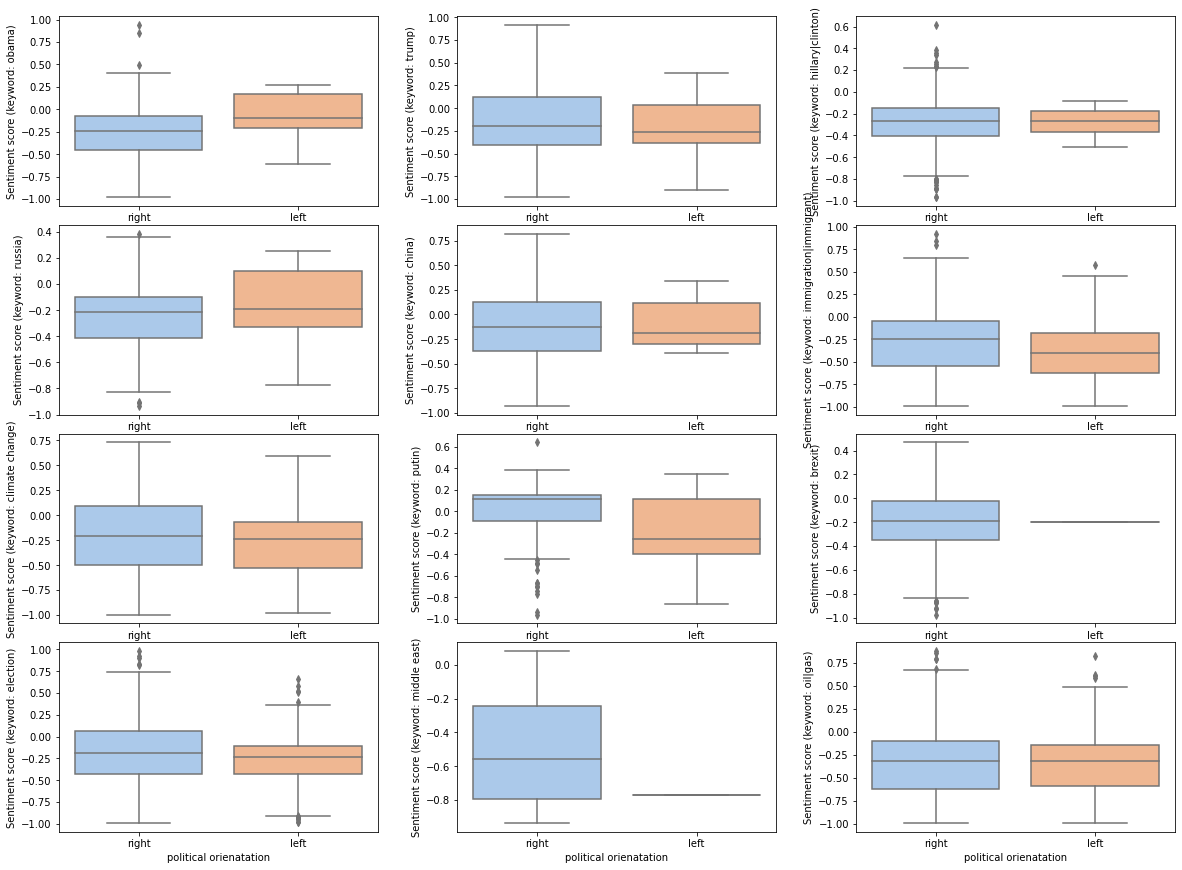

In [14]:
fig, axs = plt.subplots(4,3, figsize=(20,15),gridspec_kw={"wspace": 0.25, "hspace": 0.1})

for indx, df in enumerate(dfs):
    ax = axs[indx//3, indx%3]
    ax = sns.boxplot(ax = ax, data=df, x = df['pol_orient'], y = df['score'], palette="pastel")
    ax.set(xlabel='political orienatation', ylabel=f'Sentiment score (keyword: {keywords[indx]})')

plt.show()

In [15]:
np.random.seed(2)
for indx, df in enumerate(dfs):
    df['is_right'] = np.where((df['pol_orient'] == "right"), 1, 0)
    mod = smf.ols(formula='score ~ C(is_right)', data=df)
    # Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
    res = mod.fit()
    # Print thes summary output provided by the library.
    print(f"Regression Analysis for sentiment For Keyword: {keywords[indx]}\n", res.summary())


Regression Analysis for sentiment For Keyword: obama
                             OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     7.433
Date:                Fri, 23 Dec 2022   Prob (F-statistic):            0.00702
Time:                        15:16:00   Log-Likelihood:                -58.040
No. Observations:                 186   AIC:                             120.1
Df Residuals:                     184   BIC:                             126.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/ipykernel_launcher